# Modelo de deteccion usando Transfer Learning

 Mediante el presente cuadernillo se hara el seguimiento paso a paso por el codigo y las decisiones tomadas para abordar este problema planteado para el primer parcial donde el objetivo es generar un modelo de deteccion usando el dataset generado por el curso

In [1]:
import os
import random
from skimage import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.utils.data
import numpy as np
from torchvision import transforms
from tqdm import tqdm
from torch import nn

In [2]:
PATH = 'completados'
classes = os.listdir(PATH)
classes

['Beagle',
 'Bull_Dog_Ingles',
 'Collie',
 'Coocker',
 'GermanPointer',
 'golden_retriever',
 'hound',
 'Malamutes',
 'Pug',
 'saint_bernard',
 'Schnauzer',
 'siberian_husky']

In [3]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: Beagle. Imágenes: 5000
Categoría: Bull_Dog_Ingles. Imágenes: 5057
Categoría: Collie. Imágenes: 5011
Categoría: Coocker. Imágenes: 5000
Categoría: GermanPointer. Imágenes: 5002
Categoría: golden_retriever. Imágenes: 5000
Categoría: hound. Imágenes: 5067
Categoría: Malamutes. Imágenes: 5000
Categoría: Pug. Imágenes: 5000
Categoría: saint_bernard. Imágenes: 5347
Categoría: Schnauzer. Imágenes: 5000
Categoría: siberian_husky. Imágenes: 5000


In [4]:
imgs[:5]
len(imgs)

60484

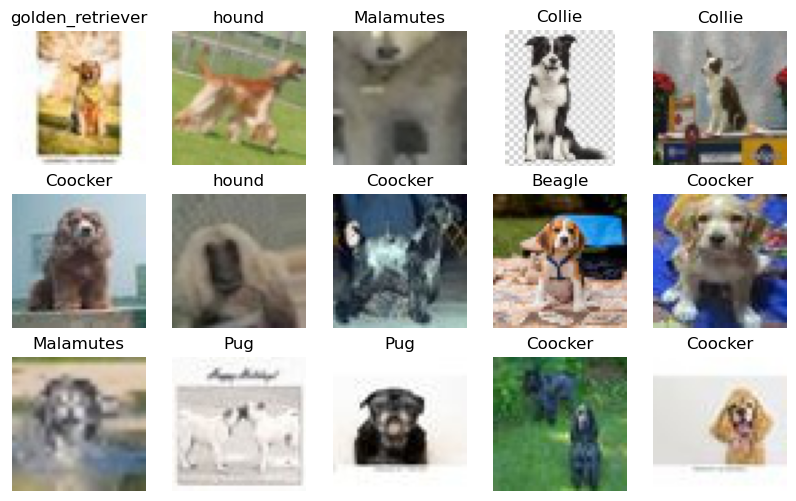

In [5]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [6]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)
len(train_imgs), len(test_imgs)

(48387, 12097)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((50, 50)),
    transforms.Lambda(lambda x: x[:3] if x.shape[0] == 4 else x)
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, device='cpu'):
        self.X = X
        self.y = y
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        # Load image from file path
        img = io.imread(self.X[ix])

        # Ensure all images have the same number of channels (RGB)
        if img.ndim == 3:
            if img.shape[2] == 4:  # RGBA
                img = img[:, :, :3]  # Remove alpha channel
        else:
            # Convert grayscale images to RGB
            img = np.stack((img,) * 3, axis=-1)
        
        # Apply the defined transform (converting to tensor and scaling)
        img = transform(img)
        
        # Convert label to tensor
        label = torch.tensor(self.y[ix], dtype=torch.long)
        
        # Move data to the correct device
        img = img.to(self.device)
        label = label.to(self.device)
        
        return img, label


In [8]:
dataset = {
    'train': Dataset(train_imgs, train_labels,device),
    'test': Dataset(test_imgs, test_labels, device)
}

len(dataset['train']), len(dataset['test'])

(48387, 12097)

In [9]:
dataset['train'][2]

(tensor([[[0.9333, 0.9059, 0.9137,  ..., 0.9882, 0.6980, 0.6314],
          [0.9333, 0.9490, 0.9647,  ..., 0.9333, 0.9686, 0.9843],
          [0.9451, 0.9647, 0.9412,  ..., 0.9725, 1.0000, 1.0000],
          ...,
          [0.7255, 0.7412, 0.7176,  ..., 0.8980, 0.8863, 0.9059],
          [0.7216, 0.7098, 0.7216,  ..., 0.8549, 0.9098, 0.9255],
          [0.6863, 0.6941, 0.7176,  ..., 0.7804, 0.8314, 0.8667]],
 
         [[0.9176, 0.8902, 0.8980,  ..., 0.9843, 0.7020, 0.6353],
          [0.9176, 0.9333, 0.9490,  ..., 0.9333, 0.9608, 0.9765],
          [0.9294, 0.9569, 0.9333,  ..., 0.9725, 0.9882, 0.9882],
          ...,
          [0.7490, 0.7647, 0.7412,  ..., 0.8392, 0.8471, 0.8667],
          [0.7490, 0.7333, 0.7255,  ..., 0.8314, 0.8667, 0.8824],
          [0.7137, 0.7176, 0.7216,  ..., 0.7569, 0.7882, 0.8235]],
 
         [[0.9216, 0.8941, 0.9020,  ..., 1.0000, 0.6314, 0.5647],
          [0.9216, 0.9373, 0.9529,  ..., 0.9412, 0.9020, 0.9176],
          [0.9333, 0.9608, 0.9373,  ...,

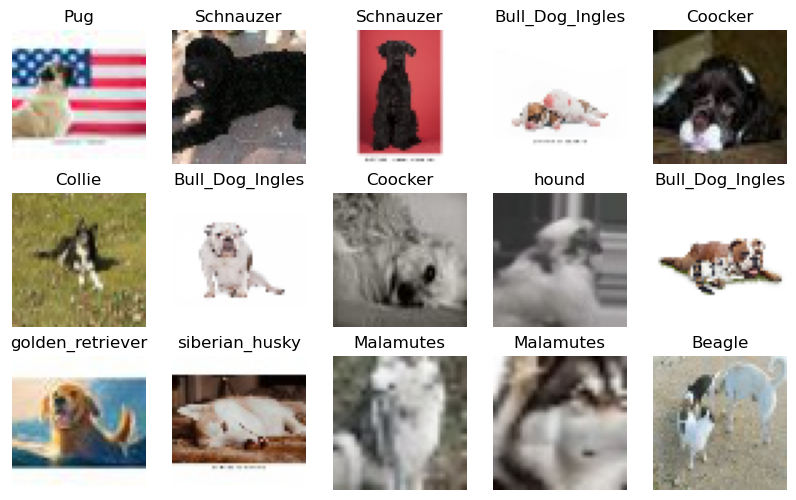

In [10]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [11]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 50, 50])

In [12]:
resnet = torchvision.models.resnet50()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
class ModelCustom(torch.nn.Module):
    def __init__(self, n_outputs=12, pretrained=False, freeze=False):
        super().__init__()
        # Load ResNet50 model
        resnet = torchvision.models.resnet50(pretrained=pretrained)
        # Remove the last layer (fully connected layer)
        self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
        # Freeze layers if specified
        if freeze:
            for param in self.resnet.parameters():
                param.requires_grad = False
        # Add a new fully connected layer for classification
        self.fc = nn.Linear(2048, n_outputs)  # ResNet50 outputs 2048-dimensional features
        
    def forward(self, x):
        # Forward pass through ResNet50
        x = self.resnet(x)
        # Flatten the features
        x = x.view(x.size(0), -1)
        # Forward pass through the new fully connected layer
        x = self.fc(x)
        return x

    def unfreeze(self):
        # Unfreeze the ResNet layers
        for param in self.resnet.parameters():
            param.requires_grad = True

In [14]:
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 50, 50))
outputs.shape

c:\Users\victus\anaconda3\envs\preTrained_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\victus\anaconda3\envs\preTrained_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 12])

In [15]:
def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [16]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader)
model_o.unfreeze()
fit(model_o, dataloader, lr=1e-4)

c:\Users\victus\anaconda3\envs\preTrained_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
val_loss 1.66254 val_acc 0.43579: 100%|██████████| 48/48 [01:51<00:00,  2.33s/it]


Epoch 1/5 loss 1.67570 val_loss 1.66254 acc 0.44948 val_acc 0.43579


val_loss 1.79526 val_acc 0.40589: 100%|██████████| 48/48 [01:15<00:00,  1.58s/it]


Epoch 2/5 loss 1.41306 val_loss 1.79526 acc 0.52676 val_acc 0.40589


val_loss 1.80870 val_acc 0.40978: 100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Epoch 3/5 loss 1.34770 val_loss 1.80870 acc 0.54621 val_acc 0.40978


val_loss 1.48138 val_acc 0.48888: 100%|██████████| 48/48 [01:15<00:00,  1.57s/it]


Epoch 4/5 loss 1.29796 val_loss 1.48138 acc 0.56129 val_acc 0.48888


val_loss 1.53095 val_acc 0.48567: 100%|██████████| 48/48 [01:14<00:00,  1.54s/it]


Epoch 5/5 loss 1.26890 val_loss 1.53095 acc 0.57213 val_acc 0.48567


val_loss 1.13708 val_acc 0.61155: 100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Epoch 1/5 loss 1.19067 val_loss 1.13708 acc 0.59314 val_acc 0.61155


val_loss 1.04294 val_acc 0.64019: 100%|██████████| 48/48 [01:39<00:00,  2.08s/it]


Epoch 2/5 loss 1.02981 val_loss 1.04294 acc 0.64961 val_acc 0.64019


val_loss 0.98598 val_acc 0.65996: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Epoch 3/5 loss 0.94698 val_loss 0.98598 acc 0.67756 val_acc 0.65996


val_loss 0.93046 val_acc 0.67761: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Epoch 4/5 loss 0.88667 val_loss 0.93046 acc 0.70025 val_acc 0.67761


val_loss 0.88849 val_acc 0.69631: 100%|██████████| 48/48 [00:49<00:00,  1.03s/it]

Epoch 5/5 loss 0.82996 val_loss 0.88849 acc 0.71770 val_acc 0.69631


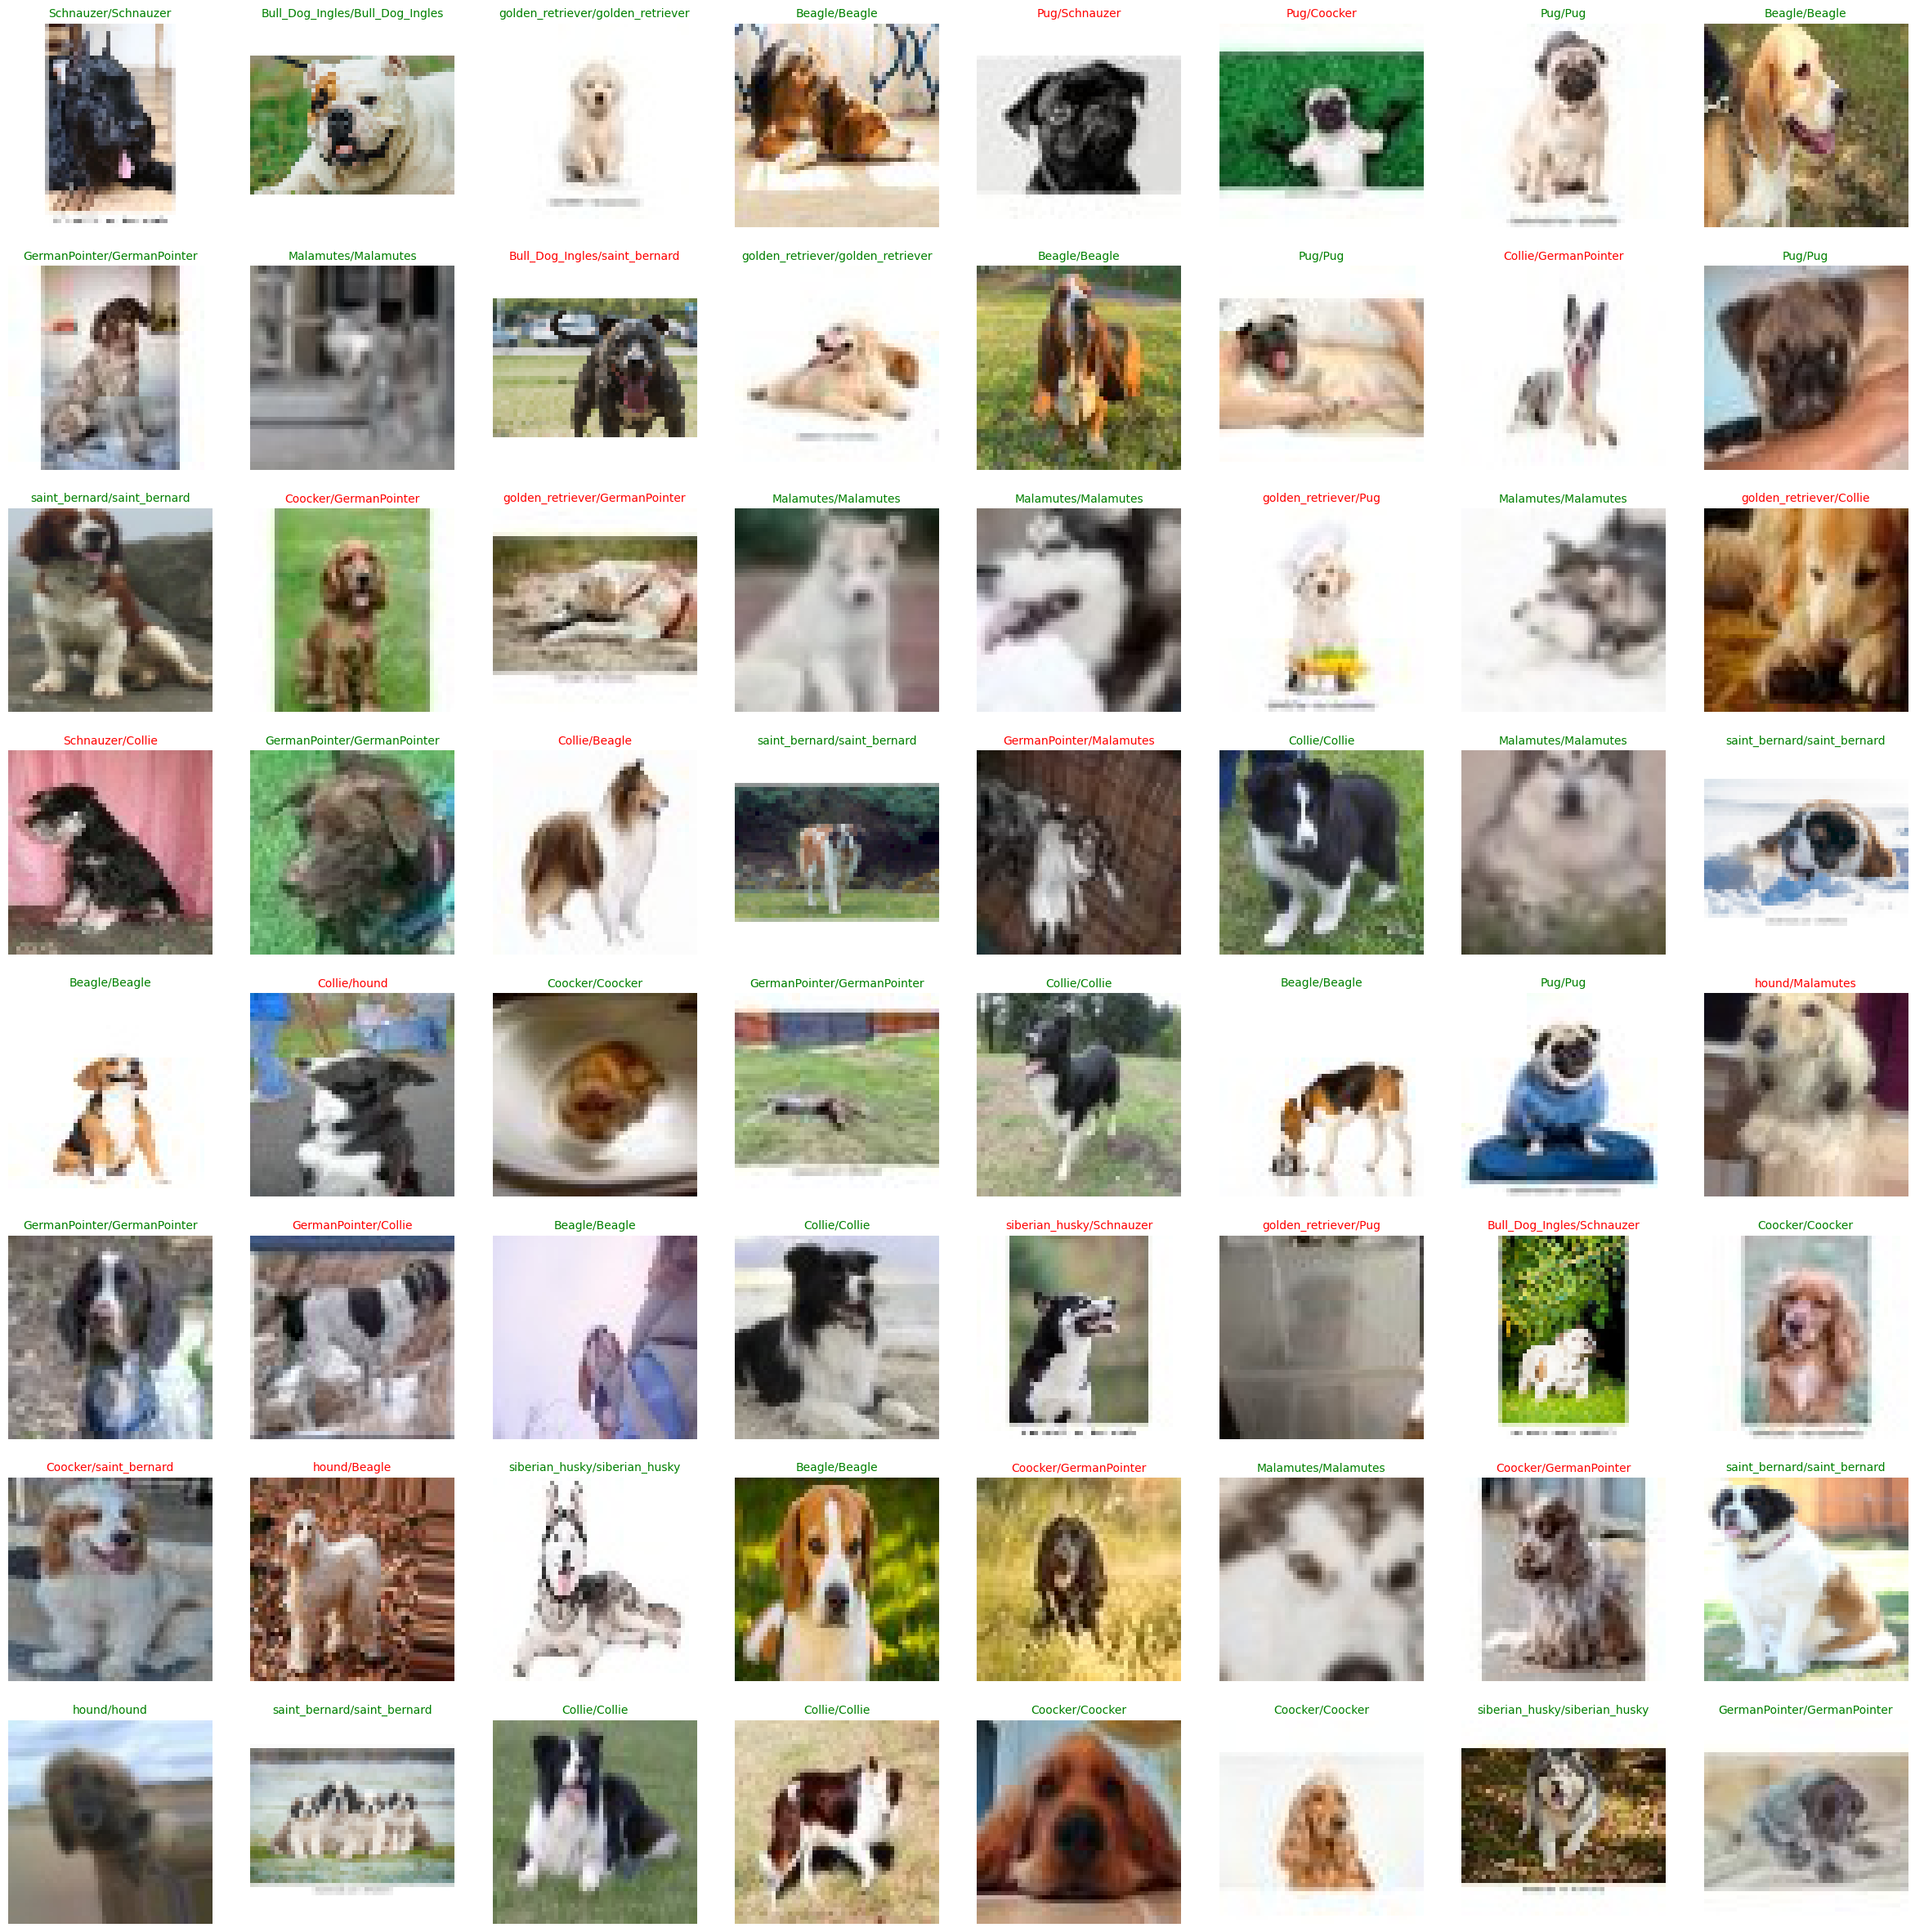

In [18]:
imgs, labels = next(iter(dataloader['test']))
model_o.eval()
with torch.no_grad():
    preds = model_o(imgs.to(device)).argmax(dim=1)

r, c = 8, 8

fig = plt.figure(figsize=(c * 3, r * 3))

class_names = [
    'Beagle',
    'Bull_Dog_Ingles',
    'Collie',
    'Coocker',
    'GermanPointer',
    'golden_retriever',
    'hound',
    'Malamutes',
    'Pug',
    'saint_bernard',
    'Schnauzer',
    'siberian_husky'
]

# Font size for the title text
font_size = 10

# Loop over the rows and columns of the grid
for _r in range(r):
    for _c in range(c):
        ix = _r * c + _c
        ax = plt.subplot(r, c, ix + 1)

        # Get the image and label for the current grid cell
        img, label = imgs[ix], labels[ix]

        # Turn off axis
        ax.axis("off")

        # Display the RGB image directly without reshaping it
        ax.imshow(img.permute(1, 2, 0))  # Permute to shape (50, 50, 3)

        # Get the predicted and true class names
        true_class = class_names[label.item()]
        pred_class = class_names[preds[ix].item()]

        # Set the title with the true and predicted class names
        # Color the title green if the prediction is correct, otherwise red
        ax.set_title(
            f'{true_class}/{pred_class}',
            color="green" if label == preds[ix] else 'red',
            fontsize=font_size
        )

# Adjust the layout of the plot
plt.tight_layout(pad=2.0)

# Show the plot
plt.show()
